In [1]:
import numpy as np
import pandas as pd
import jsonlines
from tqdm import tqdm
import matplotlib.pyplot as plt

***
## transactional data

In [2]:
!ls ../data

items_static_metadata_full.jl test_data.csv
sample_submission.csv.gz      train.parquet
scales.csv                    train_data.parquet
test.parquet                  unpredictable.csv


In [3]:
data = pd.read_parquet("../data/train_data.parquet")
data

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active
0,464801,2021-02-01,0,156.78,REA,classic,fulfillment,free_shipping,1440.000000
1,464801,2021-02-02,0,156.78,REA,classic,fulfillment,free_shipping,1440.000000
2,464801,2021-02-03,0,156.78,REA,classic,fulfillment,free_shipping,1440.000000
3,464801,2021-02-04,0,156.78,REA,classic,fulfillment,free_shipping,1440.000000
4,464801,2021-02-05,1,156.78,REA,classic,fulfillment,free_shipping,1440.000000
...,...,...,...,...,...,...,...,...,...
37660274,129187,2021-03-31,0,22057.00,ARG,classic,drop_off,free_shipping,267.710767
37660275,6707,2021-03-31,0,26999.00,ARG,classic,cross_docking,free_shipping,266.083333
37660276,170355,2021-03-31,0,3400.00,ARG,classic,drop_off,paid_shipping,0.252633
37660277,246568,2021-03-31,0,6289.00,ARG,classic,fulfillment,free_shipping,135.416667


In [4]:
data.sku.nunique()/1e3

660.916

In [5]:
data.drop_duplicates(subset=["sku"]).currency.value_counts() / 1e3

REA    336.334
MEX    265.908
ARG     58.670
DOL      0.004
Name: currency, dtype: float64

In [6]:
data.drop_duplicates(subset=["sku"]).listing_type.value_counts() / 1e3

premium    332.767
classic    328.149
Name: listing_type, dtype: float64

In [7]:
data.drop_duplicates(subset=["sku"]).shipping_logistic_type.value_counts() / 1e3

fulfillment      489.501
drop_off         104.131
cross_docking     67.284
Name: shipping_logistic_type, dtype: float64

In [8]:
data.drop_duplicates(subset=["sku"]).shipping_payment.value_counts() / 1e3

paid_shipping    438.793
free_shipping    222.123
Name: shipping_payment, dtype: float64

In [9]:
data.groupby("date")["sku"].count()

date
2021-02-01    604230
2021-02-02    606383
2021-02-03    608270
2021-02-04    610721
2021-02-05    612461
2021-02-06    613405
2021-02-07    613950
2021-02-08    615477
2021-02-09    616976
2021-02-10    618612
2021-02-11    620325
2021-02-12    621937
2021-02-13    622608
2021-02-14    622964
2021-02-15    624165
2021-02-16    625438
2021-02-17    626922
2021-02-18    628333
2021-02-19    629555
2021-02-20    630067
2021-02-21    630470
2021-02-22    631777
2021-02-23    633111
2021-02-24    634601
2021-02-25    636062
2021-02-26    637263
2021-02-27    637768
2021-02-28    638166
2021-03-01    639351
2021-03-02    640562
2021-03-03    641856
2021-03-04    643137
2021-03-05    644620
2021-03-06    645072
2021-03-07    645432
2021-03-08    646451
2021-03-09    647382
2021-03-10    648410
2021-03-11    649447
2021-03-12    650309
2021-03-13    650732
2021-03-14    651006
2021-03-15    651728
2021-03-16    652524
2021-03-17    653317
2021-03-18    654154
2021-03-19    654845
2021-03-

In [10]:
# number of rows by sku
len(data)/data.sku.nunique()

56.9819447554606

In [11]:
data.groupby("sku")["date"].count().describe()

count    660916.000000
mean         56.981945
std           8.094631
min           1.000000
25%          59.000000
50%          59.000000
75%          59.000000
max          59.000000
Name: date, dtype: float64

In [12]:
data.groupby("sku")["sold_quantity"].mean().describe()

count    660916.000000
mean          0.983020
std           6.988492
min           0.000000
25%           0.203390
50%           0.338983
75%           0.711864
max        2330.983051
Name: sold_quantity, dtype: float64

In [13]:
data.groupby("sku")["date"].count().describe()

count    660916.000000
mean         56.981945
std           8.094631
min           1.000000
25%          59.000000
50%          59.000000
75%          59.000000
max          59.000000
Name: date, dtype: float64

In [14]:
# % of null by column
data.isna().sum(axis=0)/len(data)

sku                       0.0
date                      0.0
sold_quantity             0.0
current_price             0.0
currency                  0.0
listing_type              0.0
shipping_logistic_type    0.0
shipping_payment          0.0
minutes_active            0.0
dtype: float64

***
## test data

In [15]:
test = pd.read_csv("../data/test_data.csv")

In [16]:
test.sku.nunique() / data.sku.nunique()

0.8344055825551204

In [17]:
set(test.sku) < set(data.sku)

True

In [18]:
test.target_stock.describe()

count    551472.000000
mean         18.069472
std         122.711151
min           1.000000
25%           3.000000
50%           6.000000
75%          13.000000
max       32710.000000
Name: target_stock, dtype: float64

In [19]:
data.query("sku in @test.sku").groupby(["sku"])["date"].count().describe()

count    551472.000000
mean         56.728949
std           8.642053
min           1.000000
25%          59.000000
50%          59.000000
75%          59.000000
max          59.000000
Name: date, dtype: float64

In [20]:
data.query("sku in @test.sku").groupby(["sku"])["sold_quantity"].sum().describe()

count    551472.000000
mean         57.920747
std         442.711305
min           0.000000
25%          10.000000
50%          19.000000
75%          40.000000
max      137528.000000
Name: sold_quantity, dtype: float64

***
## SKU metadata

In [21]:
all_records = list()

with jsonlines.open('../data/items_static_metadata_full.jl') as reader:
    for obj in tqdm(reader):
        all_records.append(obj)

660916it [00:03, 208931.39it/s]


In [22]:
metadata = pd.DataFrame(all_records)
metadata

,item_domain_id,item_id,item_title,site_id,sku,product_id,product_family_id
0,MLB-SNEAKERS,492155,Tênis Masculino Olympikus Cyber Barato Promoçao,MLB,0,None,MLB15832732
1,MLB-SURFBOARD_RACKS,300279,Suporte Rack Prancha Parede C/ Regulagem Horiz...,MLB,1,None,None
2,MLM-NECKLACES,69847,5 Collares Plateados Dama Gargantilla Choker -...,MLM,2,None,None
3,MLM-RINGS,298603,Lindo Anillo De Bella Crepusculo Twilight Prom...,MLM,3,None,None
4,MLB-WEBCAMS,345949,Webcam Com Microfone Hd 720p Knup Youtube Pc V...,MLB,4,None,None
...,...,...,...,...,...,...,...
660911,MLB-CELLPHONE_PARTS,320792,2 Parafuso Pentalobe Torx iPhone 5 5c 5s 6 6s ...,MLB,660911,None,None
660912,MLM-AUTOMOTIVE_EMBLEMS,90441,Emblema Circular Wolfsburg Edition 5cm,MLM,660912,None,None
660913,MLB-SOFA_AND_FUTON_COVERS,202580,Kit Capa De Sofá Coladinha Jogo 2e3 Lugares Ma...,MLB,660913,None,None
660914,MLB-SNEAKERS,490874,Calçado Sapatênis Clássico Baltic 234 Ollie,MLB,660914,None,None


In [23]:
# % of null by column
metadata.isna().sum(axis=0)/len(metadata)

item_domain_id       0.000005
item_id              0.000000
item_title           0.000000
site_id              0.000000
sku                  0.000000
product_id           0.955111
product_family_id    0.874138
dtype: float64

In [24]:
# number of categories by column
metadata.nunique()

item_domain_id         8408
item_id              517896
item_title           478175
site_id                   3
sku                  660916
product_id            15863
product_family_id     29600
dtype: int64

***
## sku with no sales

In [25]:
data.groupby("sku")["sold_quantity"].sum()[data.groupby("sku")["sold_quantity"].sum() == 0]

sku
21        0
22        0
39        0
134       0
138       0
         ..
660762    0
660807    0
660814    0
660826    0
660831    0
Name: sold_quantity, Length: 25283, dtype: int64

In [26]:
# 3.82% of skus have no sales
100 * 25283 / data.sku.nunique()

3.8254483171840294

In [27]:
nosale_skus = data.groupby("sku")["sold_quantity"].sum()[data.groupby("sku")["sold_quantity"].sum() == 0].index.values
len(nosale_skus)

25283

In [28]:
unpredictable = (set(nosale_skus) & set(test.sku))
unpredictable = pd.DataFrame(unpredictable, columns=["sku"])
display(unpredictable)
unpredictable.to_csv("../data/unpredictable.csv", index=False)

,sku
0,131072
1,524291
2,262149
3,393224
4,131085
...,...
25278,393191
25279,262125
25280,393209
25281,131068


***
## sku with few data-points

In [29]:
mask = data.query("sku not in @nosale_skus").groupby("sku")["date"].count() < 7
few_dp_skus = data.query("sku not in @nosale_skus").groupby("sku")["date"].count()[mask]
few_dp_skus

sku
1073      5
5449      5
7181      6
8288      6
13794     6
         ..
648738    3
654892    1
655809    6
659480    4
660894    6
Name: date, Length: 335, dtype: int64

***
## split sku by sales volume

In [30]:
df = (
    data
    .groupby("sku")["sold_quantity"]
    .mean()
    .sort_values(ascending=False)
    .reset_index(name="mean_sales")  
)
df["pct"] = df.mean_sales.rank(ascending=False, pct=True)
df

,sku,mean_sales,pct
0,526920,2330.983051,0.000002
1,335101,1622.559322,0.000003
2,115,1155.254237,0.000005
3,578318,1130.694915,0.000006
4,535060,1012.694915,0.000008
...,...,...,...
660911,139129,0.000000,0.980874
660912,57291,0.000000,0.980874
660913,387850,0.000000,0.980874
660914,216554,0.000000,0.980874


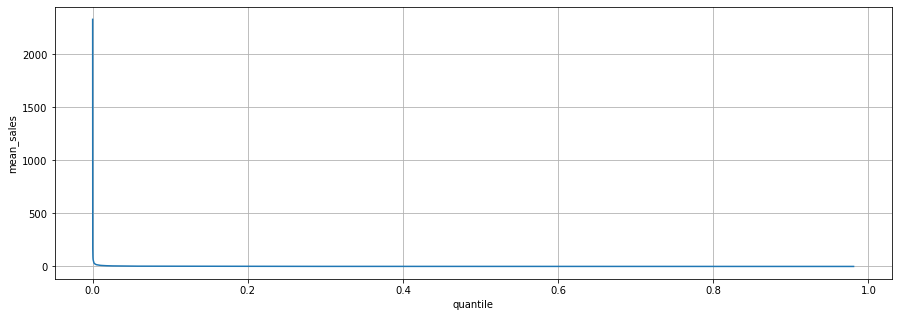

In [31]:
plt.figure(figsize=(15,5))
plt.plot(df.pct, df.mean_sales)
plt.grid()
plt.xlabel("quantile")
plt.ylabel("mean_sales")
plt.show()

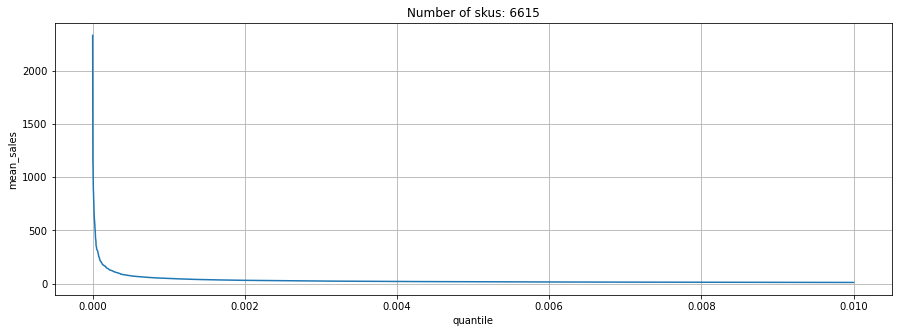

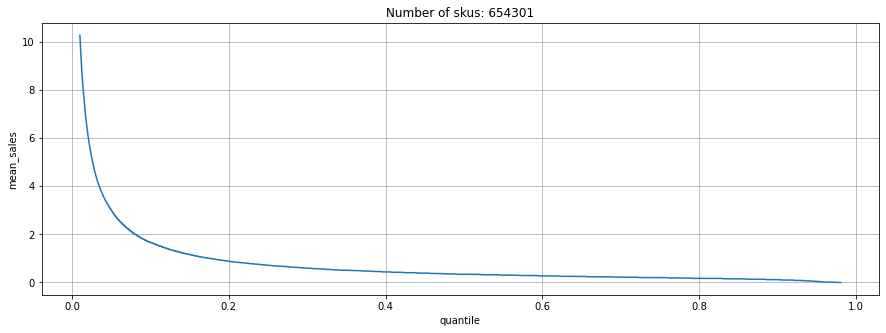

In [32]:
split_point = 0.01

plt.figure(figsize=(15,5))
plt.plot(df.query("pct <= @split_point").pct, df.query("pct <= @split_point").mean_sales)
plt.grid()
plt.xlabel("quantile")
plt.ylabel("mean_sales")
plt.title(f"Number of skus: {df.query('pct <= @split_point').sku.nunique()}")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(df.query("pct > @split_point").pct, df.query("pct > @split_point").mean_sales)
plt.grid()
plt.xlabel("quantile")
plt.ylabel("mean_sales")
plt.title(f"Number of skus: {df.query('pct > @split_point').sku.nunique()}")
plt.show()

***
## scaling factors for RMSSE

In [33]:
data.sort_values(["sku","date"], inplace=True, ignore_index=True)
data

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active
0,0,2021-02-01,0,172.79,REA,classic,cross_docking,free_shipping,0.00
1,0,2021-02-02,0,172.79,REA,classic,cross_docking,free_shipping,0.00
2,0,2021-02-03,0,179.99,REA,classic,cross_docking,free_shipping,872.65
3,0,2021-02-04,0,179.99,REA,classic,cross_docking,free_shipping,1440.00
4,0,2021-02-05,0,179.99,REA,classic,cross_docking,free_shipping,1440.00
...,...,...,...,...,...,...,...,...,...
37660274,660915,2021-03-27,0,79.99,MEX,classic,fulfillment,paid_shipping,0.00
37660275,660915,2021-03-28,0,79.99,MEX,classic,fulfillment,paid_shipping,0.00
37660276,660915,2021-03-29,0,79.99,MEX,classic,fulfillment,paid_shipping,0.00
37660277,660915,2021-03-30,0,99.99,MEX,classic,fulfillment,paid_shipping,0.00


In [34]:
scales = data.groupby("sku").apply(lambda df: np.sqrt(np.nanmean(df.sold_quantity.diff(1)**2)))
scales = scales.reset_index(name="scale")
scales["scale"] = scales["scale"].fillna(0)
scales

<ipython-input-34-25f65c262494>:1: RuntimeWarning: Mean of empty slice
  scales = data.groupby("sku").apply(lambda df: np.sqrt(np.nanmean(df.sold_quantity.diff(1)**2)))


,sku,scale
0,0,0.669534
1,1,1.025536
2,2,0.301511
3,3,0.508548
4,4,2.463527
...,...,...
660911,660911,0.830455
660912,660912,1.033908
660913,660913,0.587220
660914,660914,1.203443


In [35]:
avgs = data.groupby("sku")["sold_quantity"].mean()
avgs = avgs.reset_index(name="avg")
avgs

,sku,avg
0,0,0.186441
1,1,0.372881
2,2,0.043478
3,3,0.135593
4,4,0.661017
...,...,...
660911,660911,0.322034
660912,660912,0.237288
660913,660913,0.169492
660914,660914,0.389831


In [36]:
scales = pd.merge(scales, avgs, how="inner", on="sku")
scales

,sku,scale,avg
0,0,0.669534,0.186441
1,1,1.025536,0.372881
2,2,0.301511,0.043478
3,3,0.508548,0.135593
4,4,2.463527,0.661017
...,...,...,...
660911,660911,0.830455,0.322034
660912,660912,1.033908,0.237288
660913,660913,0.587220,0.169492
660914,660914,1.203443,0.389831


In [37]:
corr_factor = scales.eval("scale / avg").median()
corr_factor

2.7332977781658356

In [38]:
idx = scales.query("scale == 0").index
scales.loc[idx, "scale"] = scales.loc[idx, "avg"] * corr_factor
scales.query("scale == 0")

,sku,scale,avg
21,21,0.0,0.0
22,22,0.0,0.0
39,39,0.0,0.0
134,134,0.0,0.0
138,138,0.0,0.0
...,...,...,...
660762,660762,0.0,0.0
660807,660807,0.0,0.0
660814,660814,0.0,0.0
660826,660826,0.0,0.0


In [39]:
(scales
 .drop("avg", axis=1)
 .to_csv("../data/scales.csv", index=False)
)

***